In [8]:
# There is an issue with importing cli within jupyter notebooks, probably
# related to using multiprocessing. 
# import stompy.model.openfoam.cli

from stompy.spatial import field
import matplotlib.pyplot as plt
import os, sys
import numpy as np
from stompy import utils

In [2]:
%matplotlib inline

Via Command Line
--

In [4]:
# Invoke via command line:
!python -m stompy.model.openfoam.cli --help

usage: cli.py [-h] [-c CASE] [-U] [-s] [-t TIME] [-r RES] [-f]

Postprocess OpenFOAM results, esp. depth-averaging

options:
  -h, --help            show this help message and exit
  -c CASE, --case CASE  Path to case, default is working directory
  -U, --velocity        Enable depth-averaged velocity output
  -s, --stage           Enable stage (water surface elevation) output
  -t TIME, --time TIME  Select output times as comma-separated time names, or
                        'all'
  -r RES, --res RES     Output raster cell size (positive), or count in x
                        (negative)
  -f, --force           Force overwrite existing files


In [29]:
if sys.platform=='win32':
    root=r'Y:\DWR'
else:
    root="../../../raid01/data18/DWR/"
    
fp7_local = os.path.join(root,"fishpassage-DWR-7/fishpassage-DWR-7-7cms-local")

In [30]:
# THIS CAN BE SLOW! First call for a new case is very slow. Subsequent calls 
# take maybe 5s per timestep
!python -m stompy.model.openfoam.cli -c {fp7_local} -U -s -t 180 -r 0.1 -f 

Weights for Y:\DWR\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\processor4: cache file is Y:\DWR\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\processor4\cache\raster_weights-0.101x_0.101y-6191578a6f305c149db109ca10261080
Weights for Y:\DWR\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\processor0: cache file is Y:\DWR\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\processor0\cache\raster_weights-0.101x_0.101y-6191578a6f305c149db109ca10261080
Weights for Y:\DWR\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\processor7: cache file is Y:\DWR\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\processor7\cache\raster_weights-0.101x_0.101y-6191578a6f305c149db109ca10261080
Weights for Y:\DWR\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\processor2: cache file is Y:\DWR\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\processor2\cache\raster_weights-0.101x_0.101y-6191578a6f305c149db109ca10261080
Weights for Y:\DWR\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\processor3: cache file is Y:\DWR\f

In [41]:
import glob
glob.glob(os.path.join(fp7_local,"postProcessing/python/*_180.tif"))

['Y:\\DWR\\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\\postProcessing/python\\stage_180.tif',
 'Y:\\DWR\\fishpassage-DWR-7/fishpassage-DWR-7-7cms-local\\postProcessing/python\\U_180.tif']

In [42]:
# These load timename 180, a bit more interesting than 12 from the previous command
fld_wse=field.GdalGrid(os.path.join(fp7_local,"postProcessing/python/stage_180.tif"))
fld_U  =field.GdalGrid(os.path.join(fp7_local,"postProcessing/python/U_180.tif"))

Putting multiple channels as last index


In [43]:
print( "WSE output:")
print(f"  extents: {fld_wse.extents}  data shape {fld_wse.F.shape}")
print( "U output:")
print(f"  extents: {fld_U.extents}  data shape {fld_U.F.shape}")
# FIX: extents should be exact match

WSE output:
  extents: [-9.8, 9.8, -1.8287999629974372, 2.0999999999999996]  data shape (40, 196)
U output:
  extents: [-9.8, 9.8, -1.8287999629974372, 2.0999999999999996]  data shape (40, 196, 3)


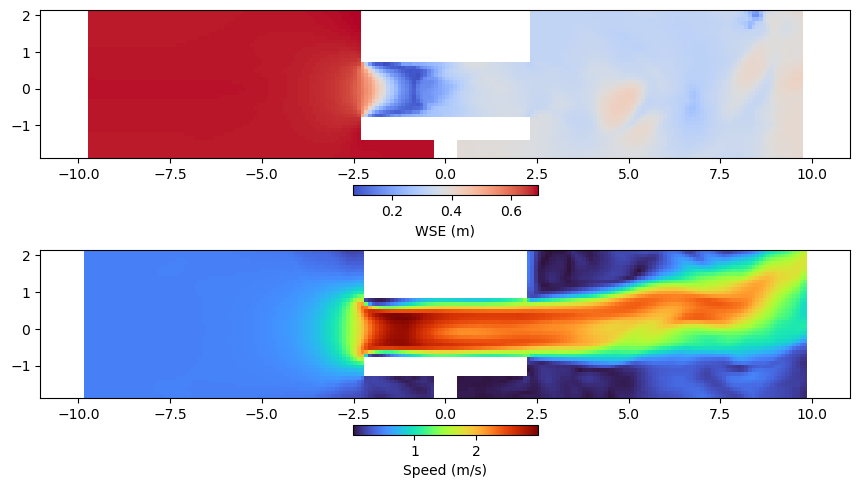

In [44]:
fig,axs=plt.subplots(2,1,figsize=(9,5))
fig.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.1,hspace=0.3)
for ax in axs:
    ax.set_adjustable('datalim')
fld_speed = field.SimpleGrid(extents=fld_U.extents, F=utils.mag(fld_U.F))
img_wse  = fld_wse.plot(ax=axs[0],cmap='coolwarm')
plt.colorbar(img_wse,label="WSE (m)",orientation='horizontal',ax=axs[0],fraction=0.05)
img_speed= fld_speed.plot(ax=axs[1],cmap='turbo')
plt.colorbar(img_speed,label="Speed (m/s)",orientation='horizontal',ax=axs[1],fraction=0.05) ;


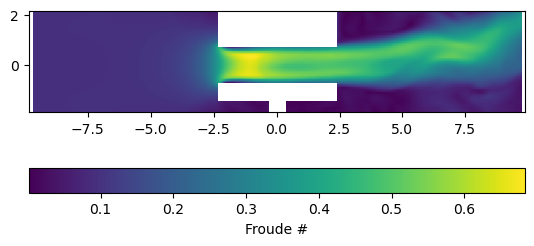

In [45]:
z_bed = -1.8288 # -6 ft, corroborated by paraview

fld_Fr = field.SimpleGrid(extents = fld_wse.extents, F=fld_speed.F/np.sqrt(9.82*(fld_wse.F+1.8288)))
fig,ax=plt.subplots()
art = fld_Fr.plot(ax=ax)
plt.colorbar(art,label="Froude #",orientation='horizontal')

Via Python
--

In [54]:
from stompy.model.openfoam import depth_average

In [55]:
pf = depth_average.PostFoam(sim_dir=os.path.join(root,"fishpassage-DWR-8/fishpassage-DWR-8-7cms"))
#pf = depth_average.PostFoam(sim_dir=os.path.join(root,"fishpassage-DWR-8/fishpassage-DWR-8hr-2cms-meshfix-rough1mm"))

Reading openfoam mesh


In [56]:
timename = pf.available_times()[-1] # will use last output time step
print(f"Will extract output for time={repr(timename)}")

Will extract output for time='179.884289284678005'


In [57]:
pf.set_raster_parameters(dx=0.1) # 0.1 ft output resolution

Reading mesh for processor 0
Reading mesh for processor 1
Reading mesh for processor 2
Reading mesh for processor 3
Reading mesh for processor 4
Reading mesh for processor 5
Reading mesh for processor 6
Reading mesh for processor 7


{'dx': 0.1,
 'dy': 0.1,
 'xxyy': [-19.7, 19.7, -1.828799962997437, 2.05],
 'nx': 393,
 'ny': 38}

In [58]:
# First time on a new run is slow, and may need access to commands from openfoam.
fld_U=pf.to_raster('U',timename)
fld_stage=pf.to_raster('wse',timename)

Reading output for processor 0
Reading file Y:\DWR\fishpassage-DWR-8/fishpassage-DWR-8-7cms\processor0\179.884289284678005\U
Reading file Y:\DWR\fishpassage-DWR-8/fishpassage-DWR-8-7cms\processor0\179.884289284678005\alpha.water
Reading output for processor 1
Reading file Y:\DWR\fishpassage-DWR-8/fishpassage-DWR-8-7cms\processor1\179.884289284678005\U
Reading file Y:\DWR\fishpassage-DWR-8/fishpassage-DWR-8-7cms\processor1\179.884289284678005\alpha.water
Reading output for processor 2
Reading file Y:\DWR\fishpassage-DWR-8/fishpassage-DWR-8-7cms\processor2\179.884289284678005\U
Reading file Y:\DWR\fishpassage-DWR-8/fishpassage-DWR-8-7cms\processor2\179.884289284678005\alpha.water
Reading output for processor 3
Reading file Y:\DWR\fishpassage-DWR-8/fishpassage-DWR-8-7cms\processor3\179.884289284678005\U
Reading file Y:\DWR\fishpassage-DWR-8/fishpassage-DWR-8-7cms\processor3\179.884289284678005\alpha.water
Reading output for processor 4
Reading file Y:\DWR\fishpassage-DWR-8/fishpassage-DWR

In [59]:
# Relevant data in the fields:
print(f"Velocity raster:  shape = {fld_U.F.shape}")
print(f"Velocity raster: extent = {fld_U.extents}")

Velocity raster:  shape = (39, 394, 3)
Velocity raster: extent = [-19.7, 19.7, -1.828799962997437, 2.05]


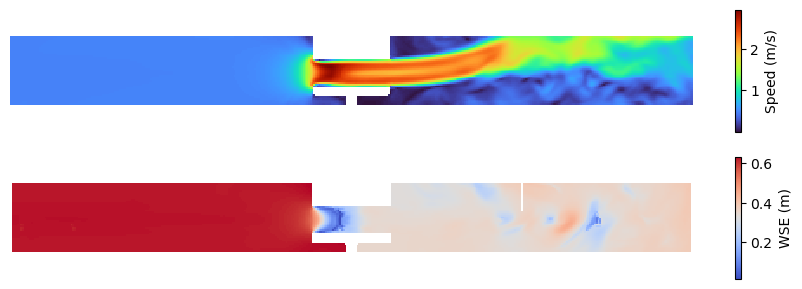

In [60]:
fig,axs = plt.subplots(2,1,figsize=(11,3.5))
for ax in axs:
    ax.set_adjustable('datalim')
    ax.axis('off')
fld_mag = field.SimpleGrid(extents=fld_U.extents,F=np.sqrt((fld_U.F**2).sum(axis=2)))
imgU = fld_mag.plot(ax=axs[0],interpolation='nearest',cmap='turbo')
imgH = fld_stage.plot(ax=axs[1],interpolation='nearest',cmap='coolwarm')
plt.colorbar(imgU,ax=axs[0],label='Speed (m/s)')
plt.colorbar(imgH,ax=axs[1],label='WSE (m)') ;

Note that WSE can have missing bands along the boundary between processors. This is a limitation of processing the data one processor at a time.